# Process viral barcode replicates
This notebook plots the correlation between technical replicates of raw viral barcode sequencing data. Then, it calculates the mean frequency of each barcode and exports this value to a CSV. Data source is supernatant or second infection.

Import Python modules:

In [1]:
from dms_variants.constants import CBPALETTE

from IPython.display import display

import gzip

import pandas as pd

import plotnine as p9

Hardcode variables for now:

In [2]:
expt = 'scProgenyProduction_trial2'
viral_bc_in_progeny_csv = '../results/viral_progeny/scProgenyProduction_trial2_viral_bc_in_progeny.csv.gz'
viral_bc_in_progeny_freq_csv = '../results/viral_progeny/scProgenyProduction_trial2_viral_bc_in_progeny_freq.csv.gz'

Load viral barcode counts and pivot dataframe so replicates in two columns.

In [9]:
viral_bc = pd.read_csv(gzip.open(viral_bc_in_progeny_csv))
viral_bc = pd.merge(viral_bc,
                    (viral_bc
                     .groupby(['source',
                               'tag',
                               'gene',
                               'replicate'])
                     .sum()
                     .reset_index()),
                     on=['source','tag','gene','replicate'],
                     suffixes=('_barcode','_total'))
viral_bc['freq'] = (viral_bc['count_barcode'] /
                    viral_bc['count_total'])
display(viral_bc)

,source,tag,gene,replicate,barcode,count_barcode,count_total,freq
0,second_infection,syn,fluHA,replicate_1,GTCAATCAAGATAAGA,17759,534814,0.033206
1,second_infection,syn,fluHA,replicate_1,CATTTACGCTGAATTG,15323,534814,0.028651
2,second_infection,syn,fluHA,replicate_1,AGCTTGGCATGAAAGA,3121,534814,0.005836
3,second_infection,syn,fluHA,replicate_1,CTTAAAAAGATTCCAG,2533,534814,0.004736
4,second_infection,syn,fluHA,replicate_1,GGTCACCGTGAGAAAT,1802,534814,0.003369
...,...,...,...,...,...,...,...,...
217012,supernatant,wt,fluNA,replicate_2,TTTTGAATGGACGGAG,1,484914,0.000002
217013,supernatant,wt,fluNA,replicate_2,TTTTGCTTCGGGATAG,1,484914,0.000002
217014,supernatant,wt,fluNA,replicate_2,TTTTGGAACAACTATA,1,484914,0.000002
217015,supernatant,wt,fluNA,replicate_2,TTTTGTCATGATAGCT,1,484914,0.000002


### Plots
Set theme for plots.

In [4]:
p9.theme_set(p9.theme_classic())

Plot number of barcodes identified for each sample:

,source,tag,gene,replicate,n_unique_barcodes
0,second_infection,syn,fluHA,replicate_1,19335
1,second_infection,syn,fluHA,replicate_2,19922
2,second_infection,syn,fluNA,replicate_1,20476
3,second_infection,syn,fluNA,replicate_2,20725
4,second_infection,wt,fluHA,replicate_1,22558
5,second_infection,wt,fluHA,replicate_2,23796
6,second_infection,wt,fluNA,replicate_1,18260
7,second_infection,wt,fluNA,replicate_2,18633
8,supernatant,syn,fluHA,replicate_1,7572
9,supernatant,syn,fluHA,replicate_2,7409


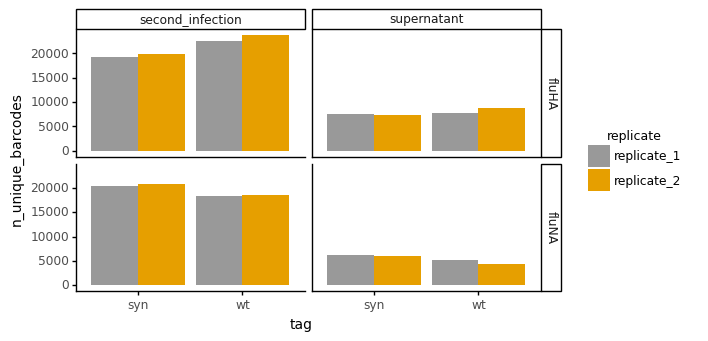

<ggplot: (8745822119614)>

In [5]:
n_barcodes_df = (viral_bc
                 .groupby(['source','tag','gene','replicate'])['barcode']
                 .nunique()
                 .reset_index()
                 .rename(columns={'barcode':'n_unique_barcodes'}))
                 
display(n_barcodes_df)

fig = (p9.ggplot(n_barcodes_df, p9.aes(x='tag',
                                       y='n_unique_barcodes',
                                       fill='replicate')) +
       p9.geom_bar(stat='identity', position='position_dodge') +
       p9.facet_grid('gene~source') + 
       p9.theme(figure_size=(3*n_barcodes_df['gene'].nunique(),
                             1.7*n_barcodes_df['source'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_fill_manual(CBPALETTE[0:]))
fig

Plot histogram for each sample:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 316 rows containing missing values.


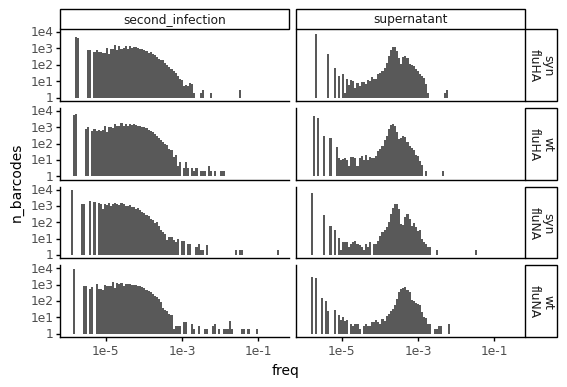

<ggplot: (8745822114856)>

In [6]:
fig = (p9.ggplot(viral_bc, p9.aes(x='freq')) +
       p9.geom_histogram(bins=100) +
       p9.facet_grid('gene+tag~source') + 
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(3*viral_bc['source'].nunique(),
                             2*viral_bc['gene'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.ylab('n_barcodes'))
fig

In [7]:
viral_barcode_counts_wide = (viral_barcode_counts
                             .pivot_table(index=['source',
                                                 'tag',
                                                 'gene',
                                                 'barcode'],
                                          columns='replicate',
                                          values='freq')
                            .reset_index()
                            .fillna(0))

viral_barcode_counts_wide.columns = ['source',
                                     'tag',
                                     'gene',
                                     'barcode',
                                     'replicate_1_freq',
                                     'replicate_2_freq']

(viral_barcode_counts_wide['present_both_replicates'] = 
 ((viral_barcode_counts_wide['replicate_1_freq'] > 0) \
   & (viral_barcode_counts_wide['replicate_2_freq'] > 0)))
 
display(viral_barcode_counts_wide)

fig = (p9.ggplot(viral_barcode_counts_wide,
                 p9.aes(x='replicate_1_freq',
                        y='replicate_2_freq',
                        color='present_both_replicates')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('source~gene+tag') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(3.5*n_barcodes_df['gene'].nunique(),
                             2*n_barcodes_df['source'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1], '#000000']))
fig.draw().show()

SyntaxError: invalid syntax (<ipython-input-7-6ecc24afdc86>, line 18)

Average frequencies and export CSV:

In [ ]:
(viral_bc_wide['mean_freq'] = ((viral_bc_wide['replicate_1_freq']
                                + viral_bc_wide['replicate_2_freq'])
                               / 2)

viral_bc_wide.to_csv(viral_bc_in_progeny_freq_csv,
                     columns=['source',
                              'tag',
                              'gene',
                              'barcode',
                              'mean_freq'],
                     index=False)